In [27]:
#!pip uninstall tensorflow -y
#!pip install tensorflow
#!pip install nltk

In [28]:
import re
import string
import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Conv1D, Dropout, GlobalMaxPooling1D, Dense, MaxPooling1D

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Subir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
print(tf.__version__)

2.10.1


**Loading the Dataset**

In [30]:
train=pd.read_table('train.txt', delimiter = ';', header=None, )
val=pd.read_table('val.txt', delimiter = ';', header=None, )
test=pd.read_table('test.txt', delimiter = ';', header=None, )

data = pd.concat([train ,  val , test])
data.columns = ["text", "label"]

In [31]:
data.shape

(20000, 2)

In [32]:
data = data.drop(data[data['label'] == 'love'].index)
data['label'].replace('joy', 'happy', inplace=True)
data.shape

C:\Users\Subir\AppData\Local\Temp\ipykernel_18076\2469187832.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['label'].replace('joy', 'happy', inplace=True)


(17438, 2)

In [33]:
data.label.unique()

array(['sadness', 'anger', 'surprise', 'fear', 'happy'], dtype=object)

In [34]:
data.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise


In [35]:
data.tail()

,text,label
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,happy
1998,im feeling more comfortable with derby i feel ...,happy
1999,i feel all weird when i have to meet w people ...,fear


In [36]:
data['label'].value_counts()

label
happy       6416
sadness     5511
anger       2574
fear        2252
surprise     685
Name: count, dtype: int64

In [37]:
#data.replace({'label': {'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5, }}, inplace=True)

In [38]:
data.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise


In [39]:
data['label'].value_counts()

label
happy       6416
sadness     5511
anger       2574
fear        2252
surprise     685
Name: count, dtype: int64

In [40]:
tweet = pd.read_csv('./tweet_emotions.csv')
tweet = tweet[(tweet.sentiment == 'neutral') | (tweet.sentiment == 'worry')| (tweet.sentiment == 'hate')]
tweet = tweet.drop('tweet_id', axis=1)
tweet = tweet[['content', 'sentiment']]
tweet.shape

(18420, 2)

In [41]:
df_list = data.values.tolist() + tweet.values.tolist()
print(len(df_list))
print(len(data.values.tolist()))
print(len(tweet.values.tolist()))

35858
17438
18420


In [42]:
df = pd.DataFrame(df_list, columns =['text', 'label'])
df.replace({'label': {"sadness": "sad", "anger": "angry", "worry": "disgust/worry/hate", "hate": "disgust/worry/hate"}}, inplace=True)

In [43]:
df['label'].value_counts()

label
disgust/worry/hate    9782
neutral               8638
happy                 6416
sad                   5511
angry                 2574
fear                  2252
surprise               685
Name: count, dtype: int64

In [44]:
df.label.unique()

array(['sad', 'angry', 'surprise', 'fear', 'happy', 'neutral',
       'disgust/worry/hate'], dtype=object)

In [45]:
def remove_urls(texts):
    # This pattern matches most common types of URLs
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', texts)

def remove_punctuation(texts):
    # This pattern matches any punctuation characters
    punctuation_pattern = f"[{re.escape(string.punctuation)}]"
    return re.sub(punctuation_pattern, '', texts)

def count_total_words(texts):
    words = re.findall(r'\b[a-zA-Z]+\b', texts)
    return len(words)

def remove_special_characters(texts):
    return re.sub(r'[^a-zA-Z0-9 ]', '', texts)

def remove_two_character_words(texts):
    cleaned_text = re.sub(r'\b[a-zA-Z]{2}\b', '', texts)
    return cleaned_text.strip()

def preprocessing(input_txt):
    words = input_txt.lower().split()
    clean_text = [word for word in words if word not in stop_words]
    clean_text = " ".join(clean_text)
    clean_text = remove_urls(clean_text)
    clean_text = re.sub(r'\B@\S+\b', '', clean_text)
    clean_text = re.sub(r'\d+', '', clean_text)
    clean_text = remove_punctuation(clean_text)
    clean_text = remove_special_characters(clean_text)
    clean_text = remove_two_character_words(clean_text)
    clean_text = '' if count_total_words(clean_text) < 2  else clean_text

    return clean_text

df["clean_text"] = df["text"].apply(lambda s: preprocessing(s))


In [46]:
df = df.drop(df[df['clean_text'] == ''].index)
df.label.unique()

array(['sad', 'angry', 'surprise', 'fear', 'happy', 'neutral',
       'disgust/worry/hate'], dtype=object)

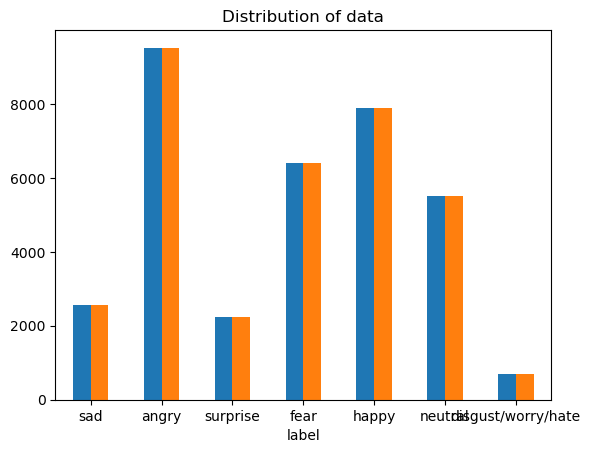

In [47]:
ax = df.groupby('label').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['sad', 'angry', 'surprise', 'fear', 'happy', 'neutral', 'disgust/worry/hate'], rotation=0)

text, label = list(df['text']), list(df['label'])

In [48]:
num_classes = df['label'].nunique()
print(num_classes)

7


In [49]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'].values)

In [50]:
df['label']

0        5
1        5
2        0
3        5
4        6
        ..
35852    4
35853    4
35854    4
35855    4
35856    4
Name: label, Length: 34847, dtype: int32

In [51]:
#split data into training data and test data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [52]:
print(train_data.shape)
print(test_data.shape)

(27877, 3)
(6970, 3)


In [53]:
# Tokenize test data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['text'])
# Save the tokenizer to a .pkl file
with open("tokenizer.pkl", 'wb') as f:
    pickle.dump(tokenizer, f)
    
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['text'].values), maxlen=50)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['text'].values), maxlen=50)

In [54]:
print(X_train)

[[   0    0    0 ...    0  142  653]
 [   0    0    0 ...  122    1   34]
 [   0    0    0 ...    2  312    9]
 ...
 [   0    0    0 ...  147   12 1087]
 [   0    0    0 ...   44    5  522]
 [   0    0    0 ...   16   25  428]]


In [55]:
print(X_train.shape)

(27877, 50)


In [56]:
print(X_test)

[[   0    0    0 ...  340   28   11]
 [   0    0    0 ...  182  145   42]
 [   0    0    0 ...   51  134 1814]
 ...
 [   0    0    0 ...    2   26   38]
 [   0    0    0 ... 1878    4  309]
 [   0    0    0 ...    1    5 1087]]


In [57]:
Y_train = train_data['label'].values
Y_test = test_data['label'].values

Y_train = to_categorical(
    Y_train, num_classes=num_classes
)
Y_test = to_categorical(
    Y_test, num_classes=num_classes
)
#print(Y_train)

In [58]:
print(Y_train.shape)

(27877, 7)


In [59]:
print(Y_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [60]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'angry': 0, 'disgust/worry/hate': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [61]:
# {'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5, }

In [62]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['label']),
    y=train_data['label']
)
class_weights = dict(enumerate(class_weights_array))

model3 = Sequential()
model3.add(Embedding(10000, 128, input_length=X_train.shape[1]))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(num_classes, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                          epochs=10, batch_size=128, verbose=2, class_weight= class_weights)

Epoch 1/10
218/218 - 33s - loss: 1.4597 - accuracy: 0.3768 - val_loss: 0.9923 - val_accuracy: 0.5247 - 33s/epoch - 151ms/step
Epoch 2/10
218/218 - 38s - loss: 0.9260 - accuracy: 0.5874 - val_loss: 0.7474 - val_accuracy: 0.6646 - 38s/epoch - 174ms/step
Epoch 3/10
218/218 - 129s - loss: 0.6102 - accuracy: 0.7297 - val_loss: 0.5975 - val_accuracy: 0.7468 - 129s/epoch - 592ms/step
Epoch 4/10
218/218 - 127s - loss: 0.4115 - accuracy: 0.8035 - val_loss: 0.5543 - val_accuracy: 0.7545 - 127s/epoch - 582ms/step
Epoch 5/10
218/218 - 54s - loss: 0.3205 - accuracy: 0.8416 - val_loss: 0.5728 - val_accuracy: 0.7555 - 54s/epoch - 249ms/step
Epoch 6/10
218/218 - 74s - loss: 0.2582 - accuracy: 0.8724 - val_loss: 0.5699 - val_accuracy: 0.7647 - 74s/epoch - 341ms/step
Epoch 7/10
218/218 - 53s - loss: 0.2162 - accuracy: 0.8928 - val_loss: 0.6079 - val_accuracy: 0.7646 - 53s/epoch - 243ms/step
Epoch 8/10
218/218 - 62s - loss: 0.1768 - accuracy: 0.9145 - val_loss: 0.6660 - val_accuracy: 0.7580 - 62s/epoch -

In [63]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            12320     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 32)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

In [64]:
loss, accuracy = model3.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

218/218 [==============================] - 6s 24ms/step - loss: 0.7286 - accuracy: 0.7669
Test Loss: 0.7285659909248352
Test Accuracy: 0.7668579816818237


In [65]:
def model_evaluate():
    # predict class with test set
    y_pred_test =  np.argmax(model3.predict(X_test), axis=1)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(Y_test,axis=1),y_pred_test)*100))

    #classification report
    print('\n')
    print(classification_report(np.argmax(Y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(Y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

218/218 [==============================] - 7s 29ms/step
Accuracy:	76.7%


              precision    recall  f1-score   support

           0       0.88      0.86      0.87       521
           1       0.65      0.64      0.65      1877
           2       0.85      0.86      0.86       456
           3       0.93      0.94      0.93      1284
           4       0.60      0.61      0.61      1585
           5       0.94      0.91      0.92      1092
           6       0.70      0.93      0.80       155

    accuracy                           0.77      6970
   macro avg       0.79      0.82      0.80      6970
weighted avg       0.77      0.77      0.77      6970



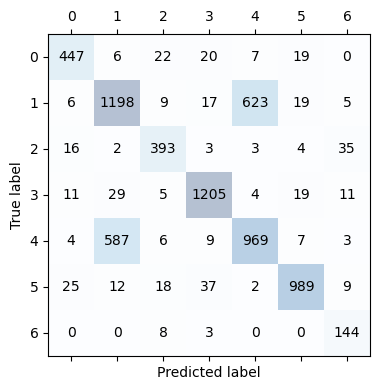

In [66]:
model_evaluate()

In [67]:
def predict_emotion(text):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([text])
  padded_sequence = pad_sequences(sequence, maxlen=50)
  prediction = model3.predict(padded_sequence)
  return prediction

new_text = "Perhaps that'll work better. I'm sorry to hear that the normal downloading approach isn't working for you."
emotion = predict_emotion(new_text)
print(f'The emotion of the review is: {emotion}')

a=np.argmax(emotion, axis=1)
print(a)
label_encoder.inverse_transform(a)[0]

1/1 [==============================] - 1s 832ms/step
The emotion of the review is: [[7.64963715e-06 7.68568456e-01 1.18080125e-05 4.12514855e-05
  2.31366128e-01 2.35836364e-06 2.41420344e-06]]
[1]


'disgust/worry/hate'

In [68]:
model3.save('Emotion_Analysis_Text.h5')

In [69]:
import json

In [70]:
emotion_txt_model = tf.keras.models.load_model('Emotion_Analysis_Text.h5')
# Show the model architecture
emotion_txt_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            12320     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 32)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

In [71]:
# Example of how to load a saved tokenizer (if you saved it as a pickle)
try:
    with open('tokenizer.pkl', 'rb') as handle:
        text_emotion_tokenizer = pickle.load(handle)
except FileNotFoundError:
    print("WARNING: text_emotion_tokenizer.pkl not found. Please ensure your tokenizer is saved and loaded correctly.")

try:
    with open('label_encoder.pkl', 'rb') as handle:
        text_emotion_label_encoder = pickle.load(handle)
except FileNotFoundError:
    print("WARNING: label_encoder.pkl not found. Please ensure your label_encoder is saved and loaded correctly.")
    text_emotion_label_encoder = LabelEncoder()
    text_emotion_label_encoder.fit(['sad', 'angry', 'surprise', 'fear', 'happy', 'neutral',
       'disgust/worry/hate'])


In [72]:
def predict_emotion_text(text):
    #print(text)
    # tokenize and pad the review
    sequence = text_emotion_tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=50)
    prediction = emotion_txt_model.predict(padded_sequence)
    predicted_key = np.argmax(prediction, axis=1)[0]
    return predicted_key
    #text_emotion_label_encoder.inverse_transform(a)[0]

In [73]:
with open("./annotations/captions_train2014.json", 'r') as f:
    annotations = json.load(f)

In [74]:
caption_list = []

for annot in annotations['annotations']:
    #print(annot)
    caption_list.append(annot)

In [75]:
for anno in caption_list:
    print(predict_emotion_text(anno['caption']))
    #print(anno['caption'])
    

1/1 [==============================] - 0s 335ms/step
4
1/1 [==============================] - 0s 37ms/step
1
1/1 [==============================] - 0s 39ms/step
4
1/1 [==============================] - 0s 37ms/step
1
1/1 [==============================] - 0s 34ms/step
1
1/1 [==============================] - 0s 37ms/step
1
1/1 [==============================] - 0s 36ms/step
1
1/1 [==============================] - 0s 38ms/step
4
1/1 [==============================] - 0s 36ms/step
4
1/1 [==============================] - 0s 35ms/step
4
1/1 [==============================] - 0s 35ms/step
1
1/1 [==============================] - 0s 35ms/step
4
1/1 [==============================] - 0s 35ms/step
4
1/1 [==============================] - 0s 35ms/step
2
1/1 [==============================] - 0s 35ms/step
4
1/1 [==============================] - 0s 35ms/step
1
1/1 [==============================] - 0s 35ms/step
4
1/1 [==============================] - 0s 35ms/step
1
1/1 [======================

KeyboardInterrupt: 